# SPIB Demo 2021
This notebook aims to serve as a simple introduction to the state predictive information bottleneck method of [Wang and Tiwary 2021](https://aip.scitation.org/doi/abs/10.1063/5.0038198). The code is implemented using Pytorch.

<img src="https://github.com/tiwarylab/State-Predictive-Information-Bottleneck/blob/main/fig/Fig_alg.png?raw=1">

<img src="https://github.com/tiwarylab/State-Predictive-Information-Bottleneck/blob/main/fig/Fig_FW_example.png?raw=1">

## Install SPIB using pypi

In [1]:
pip install spib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Clone the Github to Colab

In [2]:
!git clone https://github.com/wangdedi1997/spib

Cloning into 'spib'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 71 (delta 18), reused 66 (delta 13), pack-reused 0
Unpacking objects: 100% (71/71), 3.73 MiB | 5.39 MiB/s, done.


In [3]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.figsize'] = [25, 20]
np.random.seed(42)

In [4]:
large = 54; med = 36; small = 24
l_width = 3; m_width = 1.5; s_width = 0.7
params = {'axes.titlesize': large,
          'legend.fontsize': large,
          'legend.title_fontsize':large,
          'figure.figsize': (16, 10),
          'axes.labelsize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'lines.linewidth': l_width,
          'lines.markersize': 10,
          'axes.linewidth': l_width,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'xtick.minor.size': 4,
          'ytick.minor.size': 4,
          'xtick.major.width': m_width,
          'ytick.major.width': m_width,
          'xtick.minor.width': s_width,
          'ytick.minor.width': s_width,
          'grid.linewidth': m_width}
plt.rcParams.update(params)

Move to the ```script``` directory

In [5]:
%cd spib/scripts/

%pwd

/content/spib/scripts


'/content/spib/scripts'

## Data Preparation
The trajectory data can be generated from the molecular dynamics simulation or experiements. Here, we use a sample trajectory generated from Langevin dynamics simulation of a four-well analytical potential.

In [6]:
# Load trajectory data
traj_data = np.load("examples/Four_Well_beta3_gamma4_traj_data.npy")

### Visualization of the trajectory

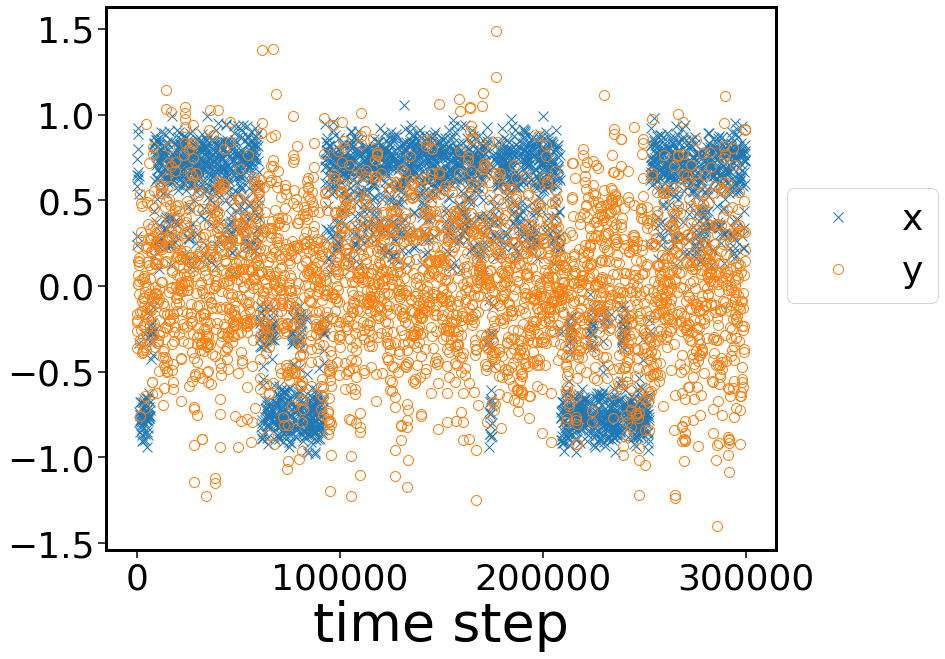

In [7]:
fig, ax = plt.subplots(figsize=(12,10))

t = np.arange(traj_data.shape[0])
ax.plot(t[::100],traj_data[::100,0],'x',label='x')
ax.plot(t[::100],traj_data[::100,1],'o',fillstyle='none',label='y')
ax.set_xlabel('time step')
ax.legend(fontsize=36,bbox_to_anchor=(0.99, 0.7))

In [8]:
# The four-well analytical potential along x
def potential_fn_FW(x):
    A=0.6
    a=80
    B=0.2
    b=80
    C=0.5
    c=40
    return 2*(x**8+A*np.exp(-a*x**2)+B*np.exp(-b*(x-0.5)**2)+C*np.exp(-c*(x+0.5)**2))+(x**2-1)**2

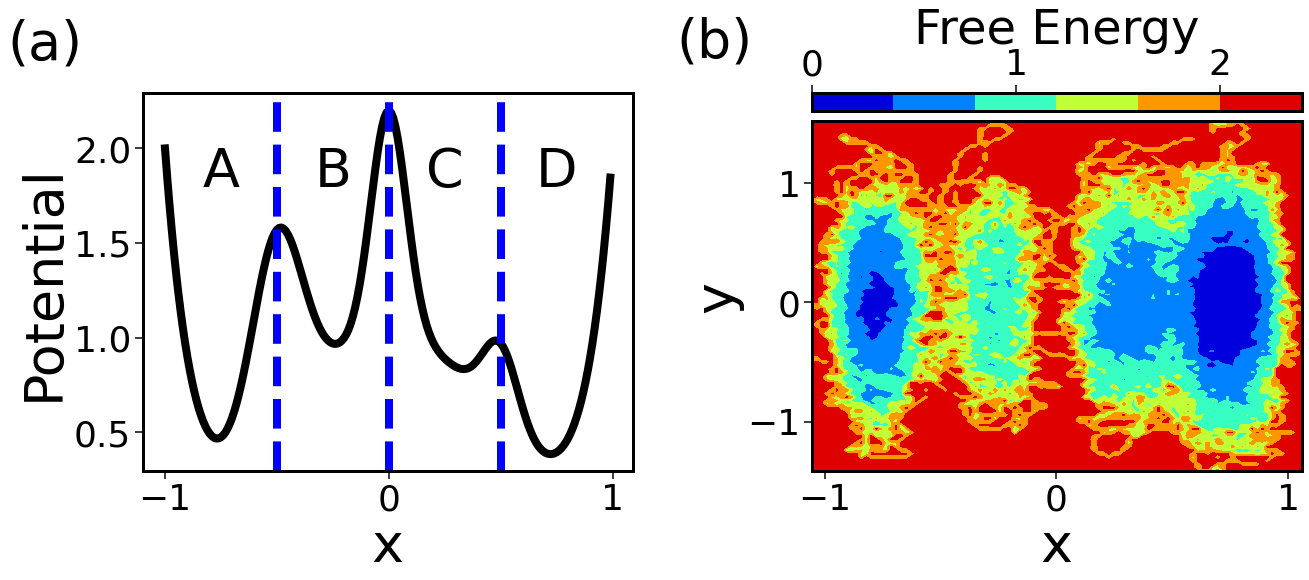

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,2,figsize=(18,8))

beta=3
lw=8

x=np.arange(-1,1,0.01)
v=potential_fn_FW(x)
ax[0].plot(x,v,color='k',lw=lw)
ax[0].axvline(x=0,color='b',linestyle='--',lw=lw)
ax[0].axvline(x=-0.5,color='b',linestyle='--',lw=lw)
ax[0].axvline(x=0.5,color='b',linestyle='--',lw=lw)
ax[0].text(-0.75, 1.8, 'A', horizontalalignment='center',fontsize=54)
ax[0].text(-0.25, 1.8, 'B', horizontalalignment='center', fontsize=54)
ax[0].text(0.25, 1.8, 'C', horizontalalignment='center',fontsize=54)
ax[0].text(0.75, 1.8, 'D', horizontalalignment='center', fontsize=54)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Potential")

ax[0].text(-0.2, 1.2, '(a)', horizontalalignment='center',
             transform=ax[0].transAxes,fontsize=54, va='top')

FW_counts,FW_xbins,FW_ybins,images = plt.hist2d(traj_data[:,0],traj_data[:,1],bins=100)
FW_counts[FW_counts==0]=FW_counts[FW_counts!=0].min()
FW_G=-np.log(FW_counts)/beta
FW_G=FW_G-np.nanmin(FW_G)

h0=ax[1].contourf(FW_G.transpose(),levels=5,extent=[FW_xbins[0],FW_xbins[-1],FW_ybins[0],FW_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,FW_G.max(),1)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label('Free Energy',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax[1].set_xlabel("x")
ax[1].set_ylabel('y')


ax[1].text(-0.2, 1.3, '(b)', horizontalalignment='center',
             transform=ax[1].transAxes,fontsize=54, va='top')

plt.tight_layout(pad=0.4, w_pad=5, h_pad=3.0)

### Generation of initial state labels

In [11]:
# discretize the system along x to 10 states as initial state labels
index=0

x_max=traj_data[:,index].max()+0.01
x_min=traj_data[:,index].min()-0.01

state_num=10
eps=1e-3

x_det=(x_max-x_min+2*eps)/state_num

init_label=np.zeros((traj_data.shape[0])).astype(int)

x_list=np.array([(x_min-eps+n*x_det) for n in range(state_num+1)])

for j in range(state_num):
    indices=(traj_data[:,index]>x_list[j])&(traj_data[:,index]<=x_list[j+1])
    init_label[indices]=j

np.save('examples/Four_Well_beta3_gamma4_init_label10.npy',init_label)

In [12]:
# plot the initial state labels for four well potential system
import matplotlib
from matplotlib import colors as c
data=traj_data
labels=init_label

fig0, ax0 = plt.subplots(figsize=(9,6))
hist=ax0.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.max()+1
state_labels=np.arange(state_num)

x_max=np.max(data[:,0])
x_min=np.min(data[:,0])

eps=1e-3

x_det=(x_max-x_min+2*eps)/state_num

x_list=np.array([(x_min-eps+n*x_det) for n in range(state_num+1)])

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=ax0.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=(labels==i))[0]
    
init_label_map=np.argmax(hist_state,axis=0).astype(float)
init_label_map[hist[0]==0]=np.nan
plt.close(fig0)

Text(0, 0.5, 'y')

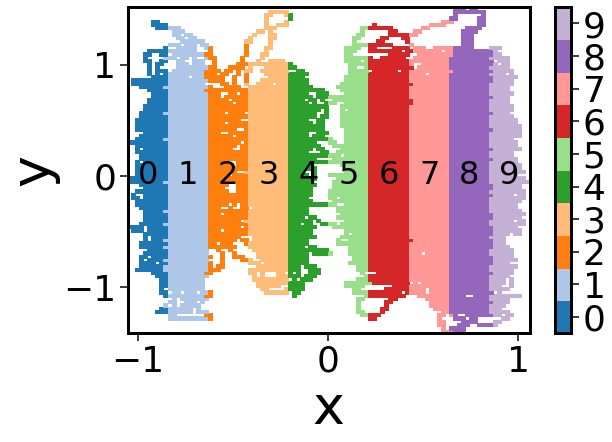

In [13]:
fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:10])
im=ax.pcolormesh(hist[1], hist[2], init_label_map.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

for i in range(state_num):
    ax.text((x_list[i]+x_list[i+1])/2,0,state_labels[i],horizontalalignment='center',verticalalignment='center',fontsize=32)
    
plt.xlabel("x")
plt.ylabel("y")

## Model
Here, we will discuss three ways to run SPIB: Using the two existing scripts (```run_spib.py``` or ```run_spib_advanced.py```) to directly run SPIB, or building your own training protocol. 

# 1. Run SPIB using ```run_spib.py```

### Training

In [14]:
%run run_spib.py -dt 50 -d 1 -encoder_type Nonlinear -bs 512 -threshold 0.05 -patience 2 -refinements 8 -lr 0.001 -b 0.01 -seed 0 -label examples/Four_Well_beta3_gamma4_init_label10.npy -traj examples/Four_Well_beta3_gamma4_traj_data.npy

Iteration 500:	Time 1.618622 s
Loss (train) 1.011448	KL loss (train): 2.238273
Reconstruction loss (train) 0.989066
Loss (test) 1.096539	KL loss (test): 2.298395
Reconstruction loss (test) 1.073555
State population:
[0.         0.2378878  0.         0.04774129 0.         0.
 0.13557445 0.         0.57879645 0.        ]
Relative state population change=0.805414
Epoch: 1

Iteration 1000:	Time 3.421001 s
Loss (train) 1.019754	KL loss (train): 2.113591
Reconstruction loss (train) 0.998619
Loss (test) 0.966962	KL loss (test): 2.084848
Reconstruction loss (test) 0.946114
State population:
[0.         0.2278565  0.         0.05789113 0.         0.
 0.15498139 0.         0.559271   0.        ]
Relative state population change=0.130964
Epoch: 2

Iteration 1500:	Time 5.187123 s
Loss (train) 0.921438	KL loss (train): 2.002879
Reconstruction loss (train) 0.901409
Loss (test) 0.965382	KL loss (test): 2.207245
Reconstruction loss (test) 0.943310
State population:
[0.         0.22757126 0.         0.

<Figure size 1152x720 with 0 Axes>

### Result Analysis

In [15]:
prefix='SPIB/Unweighted_d=1_t=50_b=0.0100_learn=0.001000'
repeat='0'

# load the results
# the deterministic part of RC leanred by SPIB (the mean of output gaussian distrition of the encoder)
traj_mean_rep=np.load(prefix+"_traj0_mean_representation"+repeat+".npy")
# the final state labels leanred by SPIB
traj_labels=np.load(prefix+"_traj0_labels"+repeat+".npy").astype(int)

Text(0, 0.5, 'y')

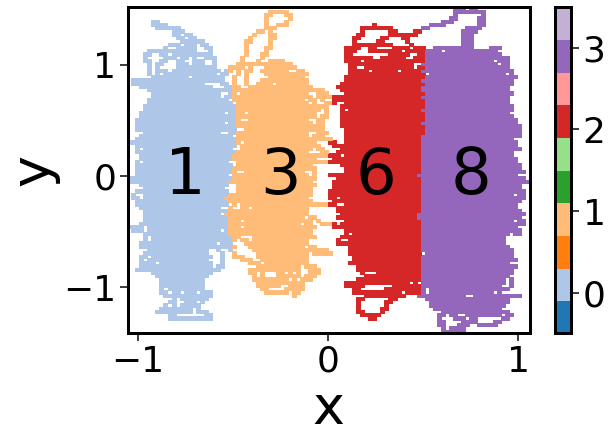

In [20]:
# plot the learned state labels for four well potential system
import matplotlib
from matplotlib import colors as c
data=traj_data
labels=traj_labels
hist=plt.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.max()+1
state_labels=np.arange(state_num)

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=(labels==i))[0]
    
label_map50=np.argmax(hist_state,axis=0).astype(float)
label_map50[hist[0]==0]=np.nan

plt.close()

fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:10])
im=ax.pcolormesh(hist[1], hist[2], label_map50.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

ax.text(-0.75,0,'1',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.75,0,'8',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(-0.25,0,'3',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.25,0,'6',horizontalalignment='center',verticalalignment='center',fontsize=64)

plt.xlabel("x")
plt.ylabel("y")

<ipython-input-22-8ee287c41eee>:3: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


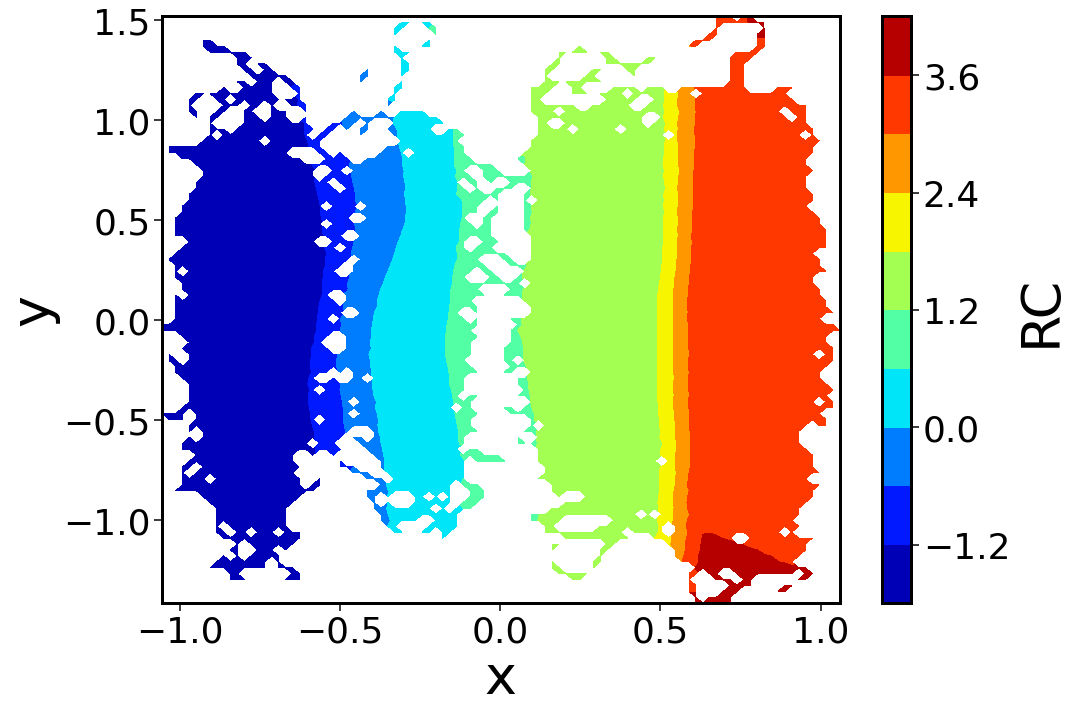

In [22]:
# plot the learned RC for four well potential system
data=traj_data

hist=plt.hist2d(data[:,0],data[:,1],bins=100)
hist_RC=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=traj_mean_rep[:,0])
plt.close()

fig, ax = plt.subplots(figsize=(15,10))

RC=np.divide(hist_RC[0],hist[0])

im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                    cmap=plt.cm.jet)
cb1 = fig.colorbar(im,ax=ax)
cb1.set_label('RC')

plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()

# Run SPIB using ```run_spib_advanced.py```

Clear the previous results

In [23]:
%rm -R SPIB

### Training

In [24]:
%run run_spib_advanced.py -config examples/sample_config.ini

Iteration 500:	Time 1.525971 s
Loss (train) 1.088399	KL loss (train): 2.270131
Reconstruction loss (train) 1.065698
Loss (test) 1.100007	KL loss (test): 2.217714
Reconstruction loss (test) 1.077830
State population:
[0.         0.2532422  0.         0.02915671 0.         0.
 0.12369839 0.         0.5939027  0.        ]
Relative state population change=0.809362
Epoch: 1

Iteration 1000:	Time 3.282954 s
Loss (train) 0.898675	KL loss (train): 2.514624
Reconstruction loss (train) 0.873529
Loss (test) 0.994458	KL loss (test): 2.572930
Reconstruction loss (test) 0.968729
State population:
[0.         0.22873442 0.         0.05674279 0.         0.
 0.14856921 0.         0.5659536  0.        ]
Relative state population change=0.486613
Epoch: 2

Iteration 1500:	Time 4.982486 s
Loss (train) 0.948381	KL loss (train): 2.594618
Reconstruction loss (train) 0.922435
Loss (test) 0.945273	KL loss (test): 2.580645
Reconstruction loss (test) 0.919467
State population:
[0.         0.22793429 0.         0.

<Figure size 1152x720 with 0 Axes>

### Result Analysis

In [25]:
prefix='SPIB/Unweighted_d=1_t=50_b=0.0100_learn=0.001000'
repeat='0'

# load the results
# the deterministic part of RC leanred by SPIB (the mean of output gaussian distrition of the encoder)
traj_mean_rep=np.load(prefix+"_traj0_mean_representation"+repeat+".npy")
# the final state labels leanred by SPIB
traj_labels=np.load(prefix+"_traj0_labels"+repeat+".npy").astype(int)

Text(0, 0.5, 'y')

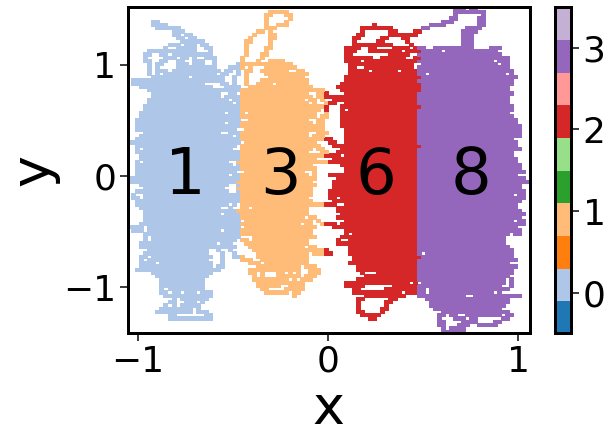

In [26]:
# plot the learned state labels for four well potential system
import matplotlib
from matplotlib import colors as c
data=traj_data
labels=traj_labels
hist=plt.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.max()+1
state_labels=np.arange(state_num)

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=(labels==i))[0]
    
label_map50=np.argmax(hist_state,axis=0).astype(float)
label_map50[hist[0]==0]=np.nan

plt.close()

fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:10])
im=ax.pcolormesh(hist[1], hist[2], label_map50.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

ax.text(-0.75,0,'1',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.75,0,'8',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(-0.25,0,'3',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.25,0,'6',horizontalalignment='center',verticalalignment='center',fontsize=64)

plt.xlabel("x")
plt.ylabel("y")

<ipython-input-27-b637c890949b>:10: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


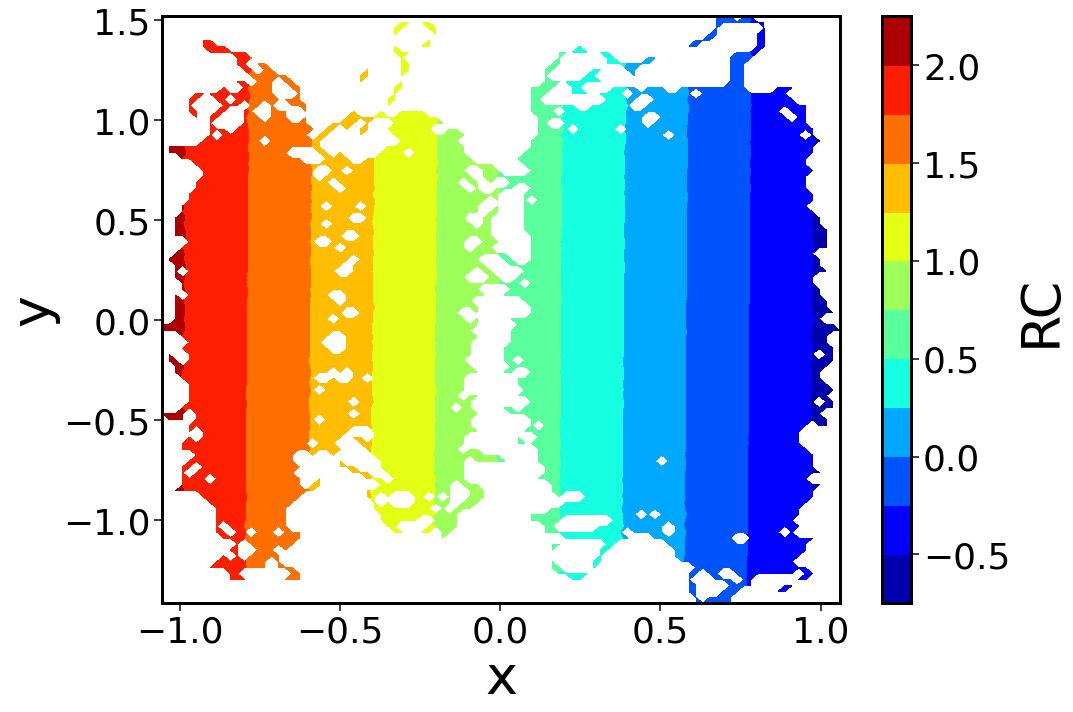

In [27]:
# plot the learned RC for four well potential system
# a linear encder is used as specified by the sample configuration file
data=traj_data

hist=plt.hist2d(data[:,0],data[:,1],bins=100)
hist_RC=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=traj_mean_rep[:,0])
plt.close()

fig, ax = plt.subplots(figsize=(15,10))

RC=np.divide(hist_RC[0],hist[0])

im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                    cmap=plt.cm.jet)
cb1 = fig.colorbar(im,ax=ax)
cb1.set_label('RC')

plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()

## 3. Run SPIB in a custom way

Clear the previous results

In [28]:
%rm -R SPIB

In [29]:
# import the required packages
import numpy as np
import torch
import os
import sys
import torch.nn.functional as F

from spib.spib import SPIB
from spib.utils import data_init

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
default_device = torch.device("cpu")
print(device, default_device)

cpu cpu


In [36]:
# Settings
# ------------------------------------------------------------------------------
# By default, we save all the results in subdirectories of the following path.
base_path = "SPIB"

# Model parameters
# Time delay delta t in terms of # of minimal time resolution of the trajectory data
dt = 50

# By default, we use all the all the data to train and test our model
t0 = 0

# Dimension of RC or bottleneck
RC_dim = 1

# Encoder type ('Linear' or 'Nonlinear')
encoder_type = 'Nonlinear'

# Number of nodes in each hidden layer of the encoder
neuron_num1 = 16

# Number of nodes in each hidden layer of the encoder
neuron_num2 = 16


# Training parameters
batch_size = 512

# Threshold in terms of the relative change of the predicted state population for measuring the convergence of the training
threshold = 0.05

# Number of epochs with the change of the state population smaller than the threshold after which this iteration of the training finishes
patience = 2

# Minimum refinements
refinements = 8

# By default, we save the model every 10000 steps
log_interval = 10000

# By default, there is no learning rate decay
lr_scheduler_step_size = 1
lr_scheduler_gamma = 1

# Initial learning rate of Adam optimizer
learning_rate = 1e-3

# Hyper-parameter beta
beta = 1e-2

# Import data
initial_label = np.load('examples/Four_Well_beta3_gamma4_init_label10.npy')
traj_data = np.load('examples/Four_Well_beta3_gamma4_traj_data.npy')

# convert numpy to torch
traj_data = torch.from_numpy(traj_data).float().to(default_device)
traj_labels = torch.from_numpy(initial_label).long().to(default_device)

output_dim = int(torch.max(traj_labels).numpy()+1)
# One-hot encoding the labels
traj_labels = F.one_hot(traj_labels, num_classes=output_dim)

traj_weights = None
IB_path = os.path.join(base_path, "Unweighted")

# Random seed
seed = 0

# Other controls

# Whether to refine the labels during the training process
UpdateLabel = True

# Whether save trajectory results
SaveTrajResults = True

# Whether save training progress
SaveTrainingProgress = False

In [37]:
# Train and Test our model
# ------------------------------------------------------------------------------

final_result_path = IB_path + '_result.dat'
os.makedirs(os.path.dirname(final_result_path), exist_ok=True)
print("Final Result", file=open(final_result_path, 'w'))

data_shape, train_past_data, train_future_data, train_data_labels, train_data_weights, \
    test_past_data, test_future_data, test_data_labels, test_data_weights = \
        data_init(t0, dt, traj_data, traj_labels, traj_weights)

output_path = IB_path + "_d=%d_t=%d_b=%.4f_learn=%f" \
    % (RC_dim, dt, beta, learning_rate)

IB = SPIB(encoder_type, RC_dim, output_dim, data_shape, device, \
    UpdateLabel, neuron_num1, neuron_num2)

IB.to(device)

# use the training set to initialize the pseudo-inputs
IB.init_representative_inputs(train_past_data, train_data_labels)

optimizer = torch.optim.Adam(IB.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)

train_result = IB.train_model(beta, train_past_data, train_future_data, \
    train_data_labels, train_data_weights, test_past_data, test_future_data, \
        test_data_labels, test_data_weights, optimizer, scheduler,\
            batch_size, threshold, patience, refinements, output_path, \
                log_interval, SaveTrainingProgress, seed)

IB.output_final_result(train_past_data, train_future_data, train_data_labels, train_data_weights, \
                        test_past_data, test_future_data, test_data_labels, test_data_weights, batch_size, \
                            output_path, final_result_path, dt, beta, learning_rate, seed)

IB.save_traj_results(traj_data, batch_size, output_path, SaveTrajResults, 0, seed)

IB.save_representative_parameters(output_path, seed)

Iteration 500:	Time 1.511947 s
Loss (train) 1.039031	KL loss (train): 2.144385
Reconstruction loss (train) 1.017587
Loss (test) 1.015978	KL loss (test): 2.328446
Reconstruction loss (test) 0.992694
State population:
[0.         0.23668389 0.         0.04887111 0.         0.
 0.131333   0.         0.583112   0.        ]
Relative state population change=0.805767
Epoch: 1

Iteration 1000:	Time 3.188229 s
Loss (train) 1.040135	KL loss (train): 2.122823
Reconstruction loss (train) 1.018907
Loss (test) 1.000622	KL loss (test): 2.085289
Reconstruction loss (test) 0.979770
State population:
[0.         0.22797874 0.         0.05794299 0.         0.
 0.15640384 0.         0.5576744  0.        ]
Relative state population change=0.136157
Epoch: 2

Iteration 1500:	Time 4.835246 s
Loss (train) 0.920640	KL loss (train): 2.178344
Reconstruction loss (train) 0.898857
Loss (test) 0.976267	KL loss (test): 2.235735
Reconstruction loss (test) 0.953910
State population:
[0.         0.22775277 0.         0.

### Result Analysis

In [42]:
prefix='SPIB/Unweighted_d=1_t=50_b=0.0100_learn=0.001000'
repeat='0'

traj_data = traj_data.cpu().data.numpy()

# load the results
# the deterministic part of RC leanred by SPIB (the mean of output gaussian distrition of the encoder)
traj_mean_rep=np.load(prefix+"_traj0_mean_representation"+repeat+".npy")
# the final state labels leanred by SPIB
traj_labels=np.load(prefix+"_traj0_labels"+repeat+".npy").astype(int)

Text(0, 0.5, 'y')

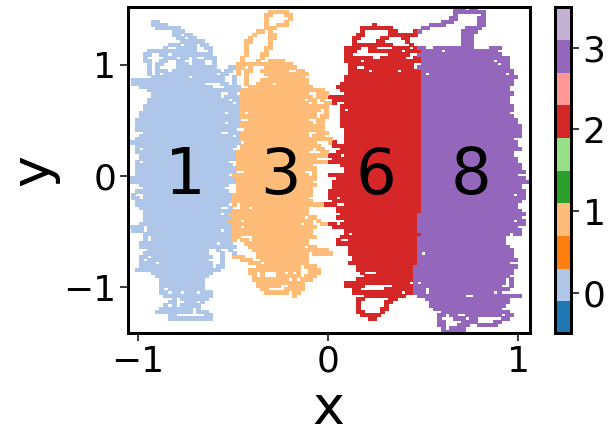

In [43]:
# plot the learned state labels for four well potential system
import matplotlib
from matplotlib import colors as c
data=traj_data
labels=traj_labels
hist=plt.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.max()+1
state_labels=np.arange(state_num)

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=(labels==i))[0]
    
label_map50=np.argmax(hist_state,axis=0).astype(float)
label_map50[hist[0]==0]=np.nan

plt.close()

fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:10])
im=ax.pcolormesh(hist[1], hist[2], label_map50.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

ax.text(-0.75,0,'1',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.75,0,'8',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(-0.25,0,'3',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.25,0,'6',horizontalalignment='center',verticalalignment='center',fontsize=64)

plt.xlabel("x")
plt.ylabel("y")

<ipython-input-44-19f957f6a925>:11: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


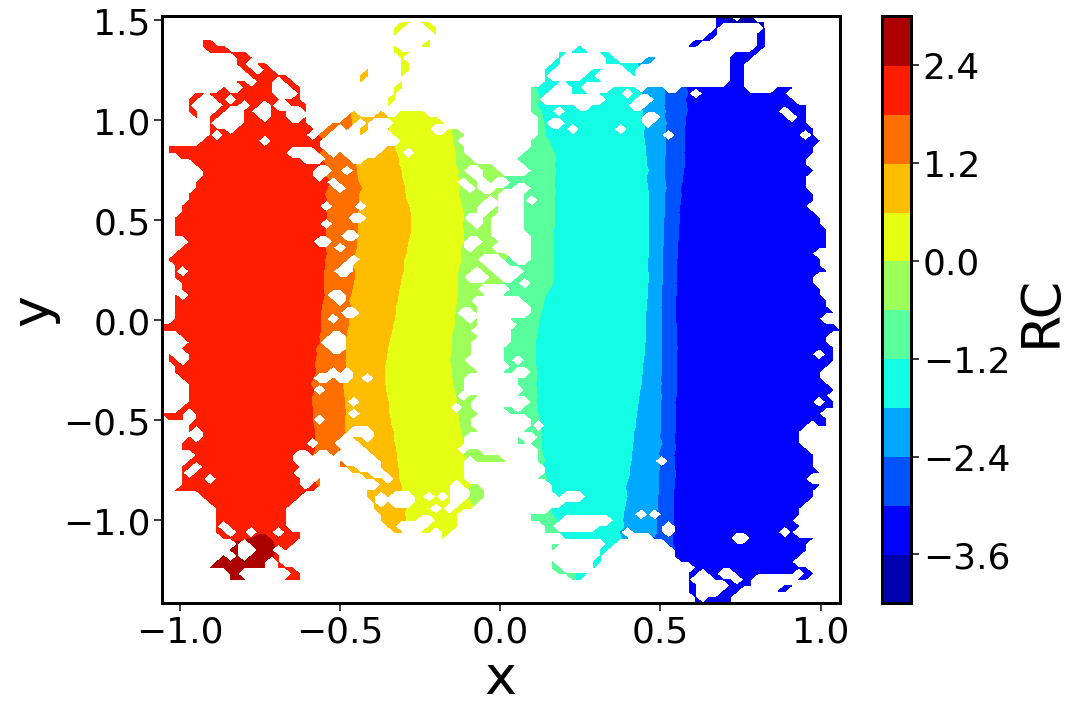

In [44]:
# plot the learned RC for four well potential system
# a linear encder is used as specified by the sample configuration file
data=traj_data

hist=plt.hist2d(data[:,0],data[:,1],bins=100)
hist_RC=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=traj_mean_rep[:,0])
plt.close()

fig, ax = plt.subplots(figsize=(15,10))

RC=np.divide(hist_RC[0],hist[0])

im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                    cmap=plt.cm.jet)
cb1 = fig.colorbar(im,ax=ax)
cb1.set_label('RC')

plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()